In [1]:
import os
import pandas as pd
import numpy as np
import glob
from pathlib import Path
import cv2
import seaborn as sns
import json
import torch
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
import gc

with open("../user_config.json") as config:
    path_dict = json.load(config)['data_paths']
    video_path = path_dict['video_path']

print("Videos: " + video_path)

Videos: /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data


In [2]:
import sklearn
sklearn.__version__

'0.21.3'

In [3]:
sys.path.append('../detector/')
from DeepFakeDetector import DeepFakeDetector
sys.path.append('../util/')

/home/joni/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
# Copy the facenet pretrained weights to cache
!mkdir -p /tmp/.cache/torch/checkpoints/
!cp ../pretrained_models/facenet_pytorch/20180402-114759-vggface2-logits.pth /tmp/.cache/torch/checkpoints/vggface2_DG3kwML46X.pt
!cp ../pretrained_models/facenet_pytorch/20180402-114759-vggface2-features.pth /tmp/.cache/torch/checkpoints/vggface2_G5aNV2VSMn.pt

In [5]:
df = pd.read_csv('../data/metadata_tr_val_split_folds.csv')
df.head()

,index,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version
0,gmuagvvcen.mp4,FAKE,1st_level,False,3,1,3.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, ...",NaN,xyioxposka.mp4,2020-02-17
1,nlbejgudfx.mp4,FAKE,1st_level,False,1,1,3.0,NaN,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",NaN,acguxjvmju.mp4,2020-02-17
2,smptxlklxc.mp4,REAL,1st_level,False,0,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
3,xmodyeeaxr.mp4,FAKE,1st_level,False,1,1,1.0,NaN,"[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, ...",NaN,ptpwappdyx.mp4,2020-02-17
4,hvxrsfgvyi.mp4,FAKE,1st_level,False,2,2,2.0,0.0,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",qelncdmypn.mp4,2020-02-17


In [6]:
# Get all test videos
filenames = []
for filename in Path(video_path).rglob('*.mp4'):
    filenames.append(filename)
print(len(filenames))

119146


In [7]:
n_first_frames = 10
n_spaced_frames = 10
pretrained_paths = '../pretrained_models/'
models_root_dir = '../kaggle_datasets/deepfake_2020_03_30/'

deepFakeDetector = DeepFakeDetector(deepfake_models_directory=models_root_dir,
                                    third_party_models_directory=pretrained_paths,
                                    n_first_frames=n_first_frames,
                                    n_spaced_frames=n_spaced_frames,
                                    #verbose=2
                                   )

cuda:0
Loaded video frame sampler.
Loaded face detectors.
Loaded pytorch facenet face embeddings model.
Loaded 0 small face classifier and 3 large face classifier models.
0 - Large face model: ../kaggle_datasets/deepfake_2020_03_30/large_face_classifier/2020_02_14-f4
1 - Large face model: ../kaggle_datasets/deepfake_2020_03_30/large_face_classifier/2020_03_12-f2
2 - Large face model: ../kaggle_datasets/deepfake_2020_03_30/large_face_classifier/2020_03_21-f1
RecurrrentModelConfig: len_sequence 5, min_frame_index 10, max_frame_index 16
Loaded 1 face sequence classifier models.
Loaded 5 second level xgb classifier models, 5 logistic regression models and 5 LightGBM models
##################################################
DeepFakeDetector v.0.8.1
Sample 10 first frames and 10 spaced frames.
Number of max retries is 4
On error cases, predict 0.5
##################################################


In [8]:
featNames = deepFakeDetector.GetFeatureNames()
print("Num features: " + str(len(featNames)))
featNames

Num features: 70


array(['large_face_clf_mean_0_original_first', 'large_face_clf_max_0_original_first',
       'large_face_clf_std_0_original_first', 'large_face_clf_median_0_original_first', ...,
       'seq_clf_len-5_start-10_0_bright_mean', 'seq_clf_len-5_start-10_0_bright_max',
       'seq_clf_len-5_start-10_0_zoom_mean', 'seq_clf_len-5_start-10_0_zoom_max'], dtype='<U48')

In [9]:
%%time
feats = deepFakeDetector.GetFeatures(filenames[2], apply_augmentations=True) # 9008, 43337, 8298
feats

CPU times: user 7.08 s, sys: 175 ms, total: 7.25 s
Wall time: 2.7 s


[array([0.30349 , 0.853458, 0.249531, 0.192149, ..., 0.981607, 0.990536, 0.995528, 0.996559])]

In [10]:
for (feat, name) in zip(feats[0],featNames):
    print(feat, name)

0.3034898881084302 large_face_clf_mean_0_original_first
0.8534576296806335 large_face_clf_max_0_original_first
0.24953143754618642 large_face_clf_std_0_original_first
0.1921488344669342 large_face_clf_median_0_original_first
0.4142199084162712 large_face_clf_Q3_0_original_first
0.7494189432702978 large_face_clf_mean_0_original_spaced
0.9712806344032288 large_face_clf_max_0_original_spaced
0.21922480718579015 large_face_clf_std_0_original_spaced
0.7761543989181519 large_face_clf_median_0_original_spaced
0.936457097530365 large_face_clf_Q3_0_original_spaced
0.8279419870195084 large_face_clf_mean_1_original_first
0.9281348586082458 large_face_clf_max_1_original_first
0.10212211978668871 large_face_clf_std_1_original_first
0.8629776239395142 large_face_clf_median_1_original_first
0.9193620383739471 large_face_clf_Q3_1_original_first
0.8100219295690598 large_face_clf_mean_1_original_spaced
0.949195384979248 large_face_clf_max_1_original_spaced
0.14934623173623401 large_face_clf_std_1_origin

In [11]:
datasOfTrackedPersons = deepFakeDetector.GetFeatures(filenames[0],return_data=True, apply_augmentations=True)

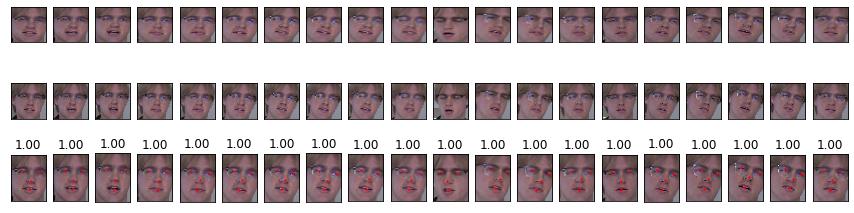

In [12]:
from detectorDebugUtils import *
plotFaceSamples(datasOfTrackedPersons, n_frames=20)

In [13]:
df = df[df['isVal']==True]
df = df[df['cv_fold']<999]
df.head()

,index,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version
7,hrkquvytxp.mp4,FAKE,2nd_level,True,4,1,2.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",NaN,dqypurwdyr.mp4,2020-02-17
25,sacjkenugu.mp4,REAL,2nd_level,True,4,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
26,eerbsimaoy.mp4,FAKE,2nd_level,True,2,2,3.0,2.0,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, ...",pfvywdrbno.mp4,2020-02-17
27,mquozjaiiw.mp4,REAL,2nd_level,True,2,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
31,kvvbxazeln.mp4,FAKE,2nd_level,True,1,1,3.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, ...",NaN,aigfuneurk.mp4,2020-02-17


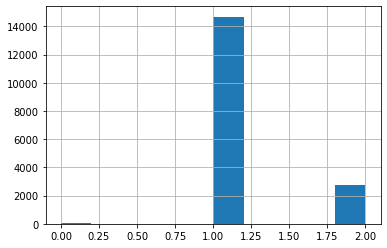

In [14]:
df.person_count.hist()

In [15]:
df.first_person_label.describe()

count    17461.000000
mean         1.565775
std          1.291520
min          0.000000
25%          0.000000
50%          2.000000
75%          2.000000
max          4.000000
Name: first_person_label, dtype: float64

In [16]:
df = df.set_index('index')
df.head()

,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version
index,,,,,,,,,,,
hrkquvytxp.mp4,FAKE,2nd_level,True,4,1,2.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",NaN,dqypurwdyr.mp4,2020-02-17
sacjkenugu.mp4,REAL,2nd_level,True,4,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
eerbsimaoy.mp4,FAKE,2nd_level,True,2,2,3.0,2.0,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, ...",pfvywdrbno.mp4,2020-02-17
mquozjaiiw.mp4,REAL,2nd_level,True,2,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
kvvbxazeln.mp4,FAKE,2nd_level,True,1,1,3.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, ...",NaN,aigfuneurk.mp4,2020-02-17


In [17]:
df_one_person = df[df['person_count']==1]
fake_real_ratio = len(df_one_person[df_one_person['label']=='FAKE']) / len(df_one_person[df_one_person['label']=='REAL'])
print('There are {0:.2} times more fakes'.format(fake_real_ratio))

There are 2.7 times more fakes


In [18]:
MISSING_VAL = 0.5

In [19]:
df_one_person.head()

,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version
index,,,,,,,,,,,
hrkquvytxp.mp4,FAKE,2nd_level,True,4,1,2.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",NaN,dqypurwdyr.mp4,2020-02-17
sacjkenugu.mp4,REAL,2nd_level,True,4,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
mquozjaiiw.mp4,REAL,2nd_level,True,2,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17
kvvbxazeln.mp4,FAKE,2nd_level,True,1,1,3.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, ...",NaN,aigfuneurk.mp4,2020-02-17
lxkyjjvhox.mp4,FAKE,2nd_level,True,0,1,1.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, ...",NaN,mjqtuozaey.mp4,2020-02-17


In [20]:
from tqdm.notebook import tqdm as tqdm
import random
random.seed(2020)

subsample = 1000

#raw lists
preds_fake = []
preds_real = []

split_fake = []
split_real = []

keys=df_one_person.index.values
feat_len = featNames.shape[0]

for i, filename in enumerate(tqdm(filenames)):#[:subsample])):
    if i%500==0: # all garbage is not handled right
        gc.collect()
        
    plain_name = str(filename).split('/')[len(str(filename).split('/'))-1]
    if plain_name not in keys:
        continue
    is_fake = True if df_one_person.at[plain_name,'label'] == 'FAKE' else False
    
    #sample fakes the same amount as reals and sample randomly
    if is_fake and random.randint(0,int(round(10*fake_real_ratio))) >= 10:
        continue
    
    split = df_one_person.at[plain_name,'cv_fold']
    try:
        preds = deepFakeDetector.GetFeatures(str(filename), apply_augmentations=True)
    except:
        print("Error with " + str(filename) + ' - ' + str(i))
        if is_fake:
            preds_fake.append(np.ones(feat_len,np.float32)*MISSING_VAL)
            split_fake.append(split)
        else:
            preds_real.append(np.ones(feat_len,np.float32)*MISSING_VAL)
            split_real.append(split)
        continue
        
    def _addPred(preds, split, is_fake):
        if is_fake:
            preds_fake.append(preds)
            split_fake.append(split)
        else:
            preds_real.append(preds)
            split_real.append(split)
    
    # preds can have two persons
    if len(preds) > 1:
        continue # skip for now
        # include both
        first_label = df_one_person.loc[plain_name]['first_person_label']
        second_label = df_one_person.loc[plain_name]['second_person_label']
        if first_label == 0:
            _addPred(preds[0], split, False)
        elif first_label > 0:
            _addPred(preds[0], split, True)
            
        # this assumes the face order is the same
        if second_label == 0:
            _addPred(preds[1], split, False)
        elif second_label > 0:
            _addPred(preds[1], split, True)
    else:
        _addPred(preds[0], split, is_fake)

Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_16/poahumqnsp.mp4 - 1239
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_16/vbylthsdar.mp4 - 1675
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_10/ewhdymgjmo.mp4 - 22535
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_10/sjeyosrvxx.mp4 - 24189
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_10/tuzqnzmysx.mp4 - 24384
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_10/usjaafgemb.mp4 - 24516
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_12/niuurktsiv.mp4 - 28435
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_20/kzvzrzyrsp.mp4 - 46734
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_20/sxrorqczon.mp4 - 47364
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_20/uunrfposre.mp4 - 47505
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/De

Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/bthkrdubbz.mp4 - 109095
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/dbthqamhyz.mp4 - 109188
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/eecvubghfz.mp4 - 109280
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/egjrqbcgym.mp4 - 109286
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/ehwcyxmtmb.mp4 - 109295
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/ehwoohpulw.mp4 - 109296
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/ekwglpkqms.mp4 - 109303
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/fiiqfocsvl.mp4 - 109352
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/fxgpgffbkt.mp4 - 109404
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_46/gndwznamgn.mp4 - 109451
Error with /mnt/945C2D6E5C2D4B

Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_48/uxlrcicjge.mp4 - 115697
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_48/xmephobexu.mp4 - 115789
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/agblhurdrh.mp4 - 116040
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/apdmamltet.mp4 - 116073
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/avlbihahvk.mp4 - 116117
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/axsgyeohxb.mp4 - 116126
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/bmgidxpirq.mp4 - 116191
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/bvfxnmejnh.mp4 - 116235
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/cimlotvwxy.mp4 - 116296
Error with /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data/dfdc_train_part_49/dermobcmbu.mp4 - 116393
Error with /mnt/945C2D6E5C2D4B

In [21]:
# is the set balanced?
print(len(preds_real), len(preds_fake))

3945 3773


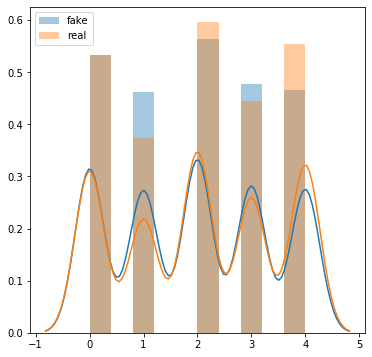

In [22]:
# are the splits balanced?
f, ax = plt.subplots(1,1,figsize=(6,6))
sns.distplot(split_fake,bins=10, ax=ax, label='fake')
sns.distplot(split_real,bins=10, ax=ax, label='real')
ax.legend()

# Plot distributions for each feature

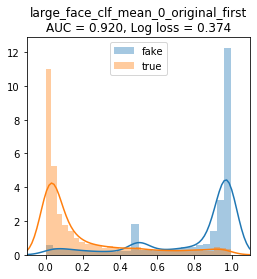

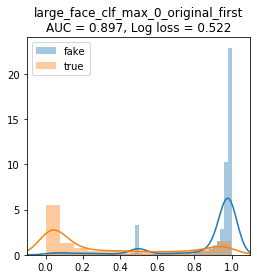

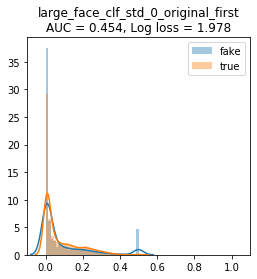

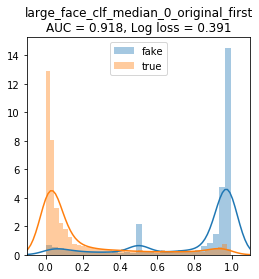

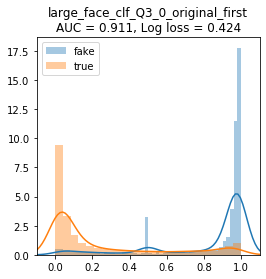

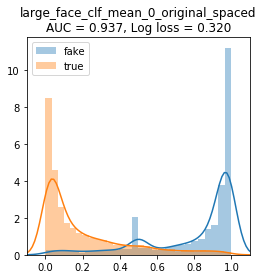

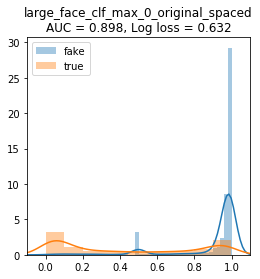

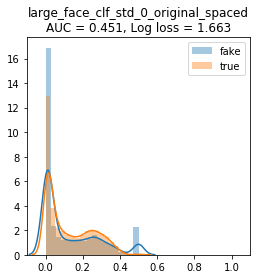

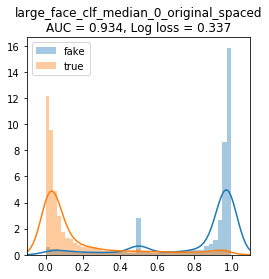

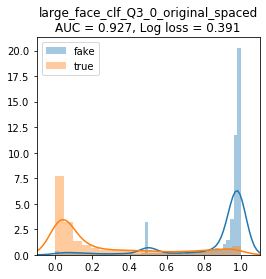

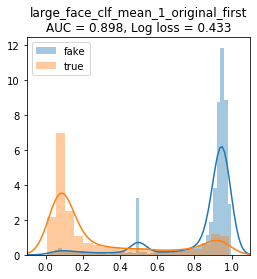

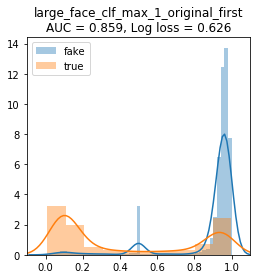

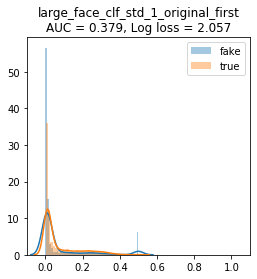

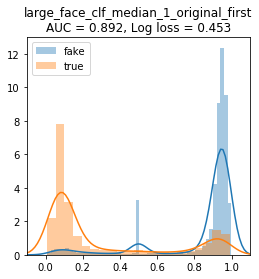

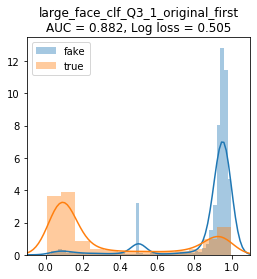

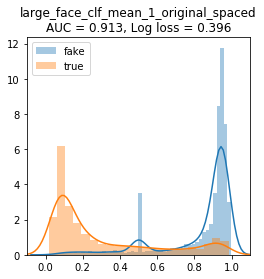

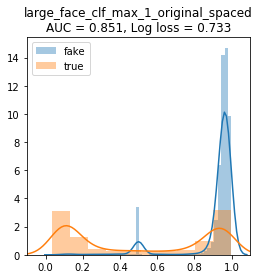

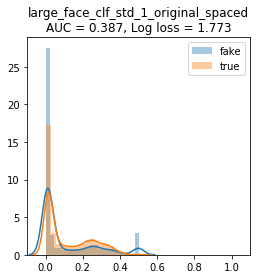

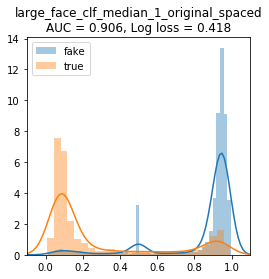

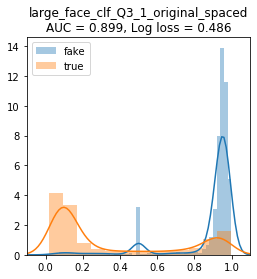

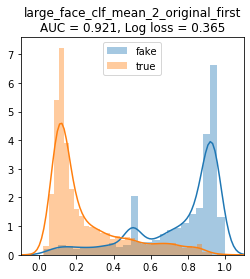

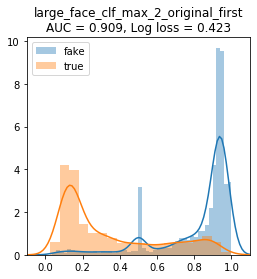

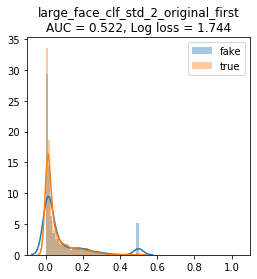

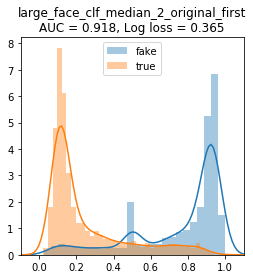

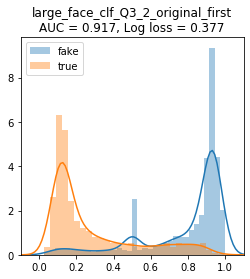

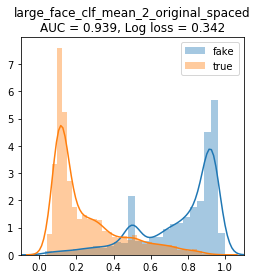

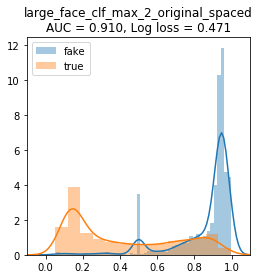

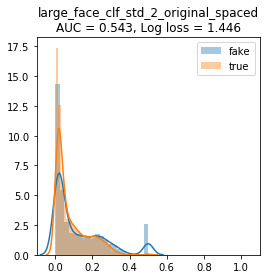

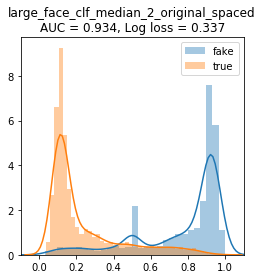

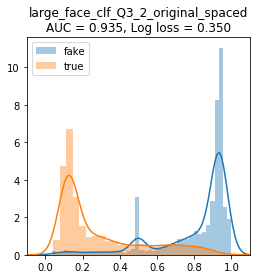

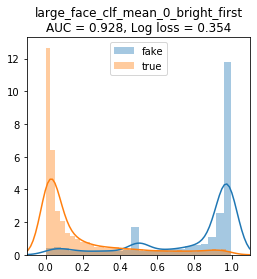

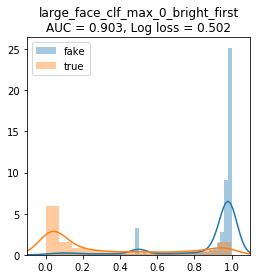

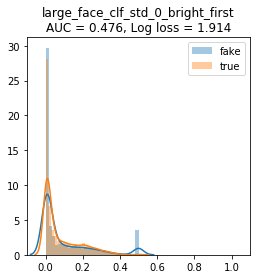

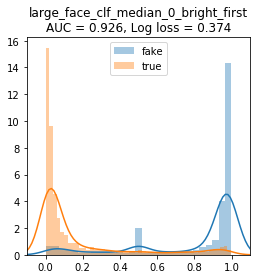

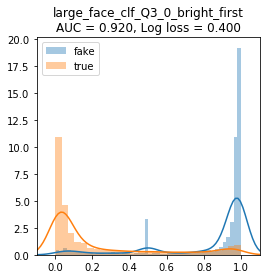

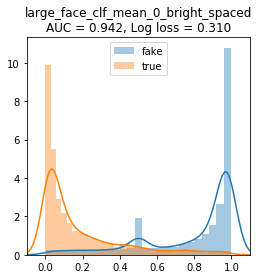

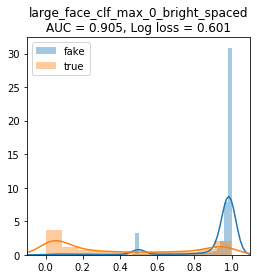

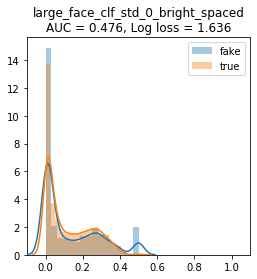

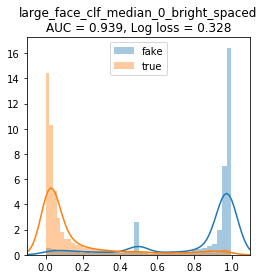

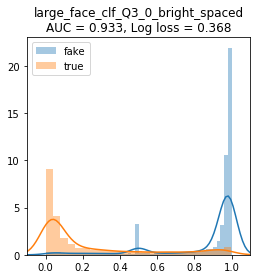

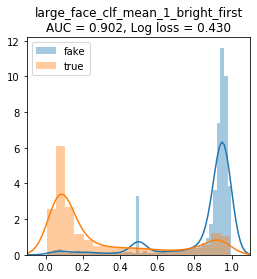

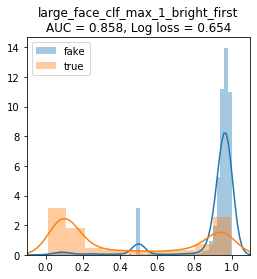

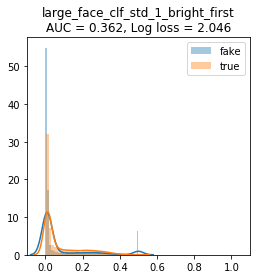

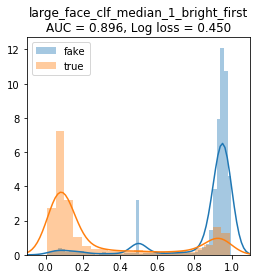

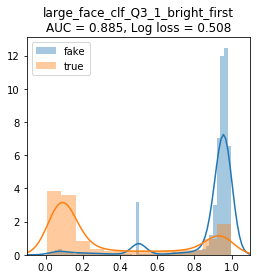

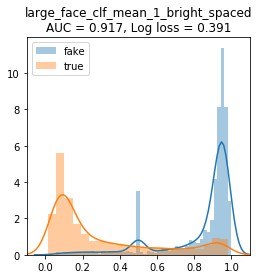

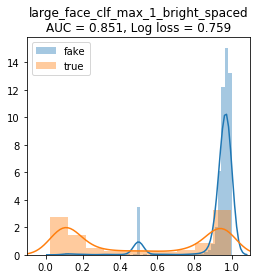

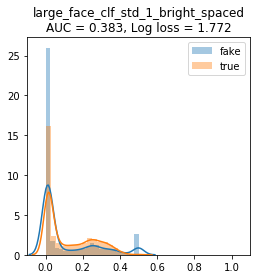

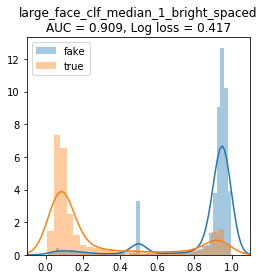

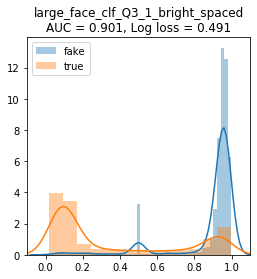

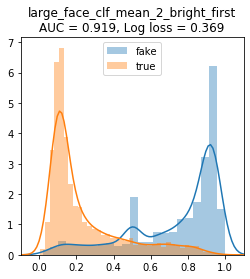

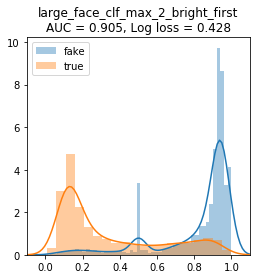

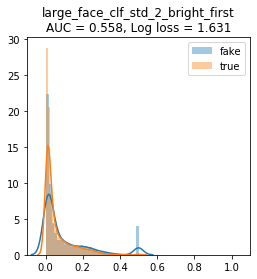

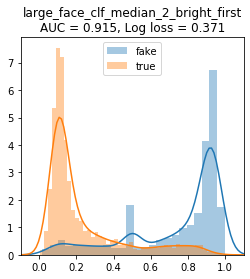

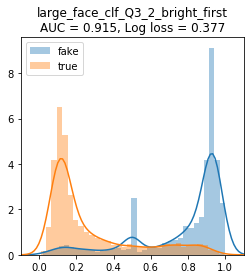

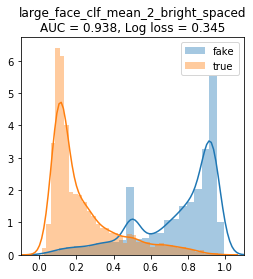

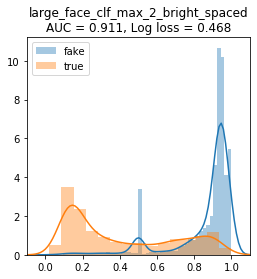

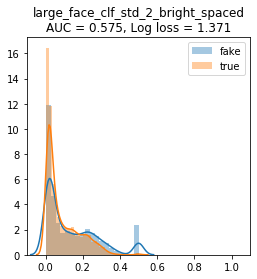

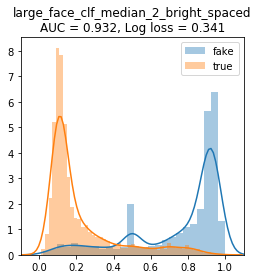

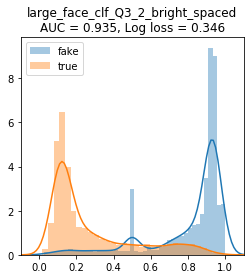

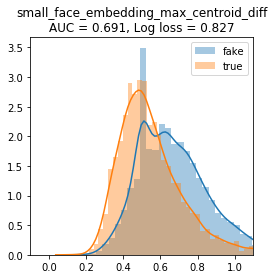

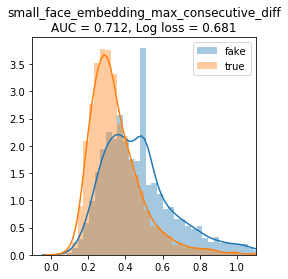

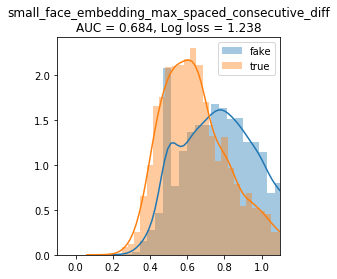

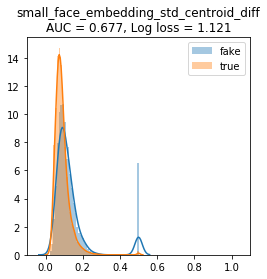

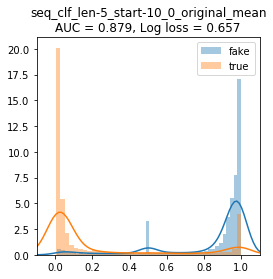

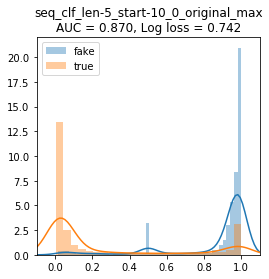

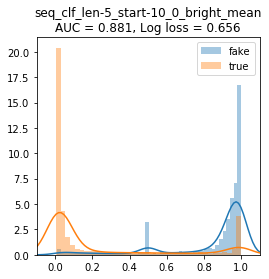

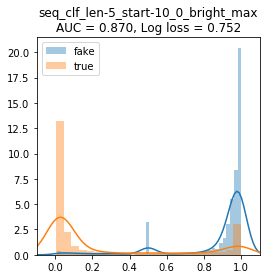

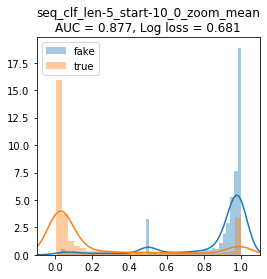

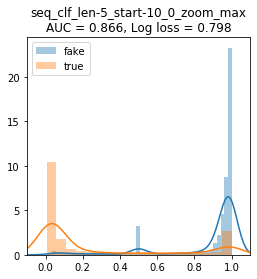

In [23]:
import matplotlib.axes
from sklearn.metrics import roc_auc_score, log_loss

def getAuc(fake_list, real_list):
    true_labels = np.concatenate([np.ones(len(fake_list)), np.zeros(len(real_list))])
    pred_labels = np.array(fake_list + real_list)
    return roc_auc_score(true_labels,pred_labels)

def getLogLoss(fake_list, real_list, eps=1e-6):
    true_labels = np.concatenate([np.ones(len(fake_list)), np.zeros(len(real_list))])
    pred_labels = np.array(fake_list + real_list)
    # epsilon clip to avoid nans
    pred_labels = np.clip(pred_labels,eps,1-eps)
    return log_loss(true_labels,pred_labels)

def plotFakeReal(feature_index):
    fake_list = list(np.array(preds_fake)[:,feature_index])
    real_list = list(np.array(preds_real)[:,feature_index])
    auc = getAuc(fake_list, real_list)
    logloss = getLogLoss(fake_list, real_list)
    f, ax = plt.subplots(1,1,figsize=(4,4))
    sns.distplot(fake_list, ax=ax, label='fake')
    sns.distplot(real_list, ax=ax, label='true')
    ax.set_title(featNames[feature_index] + '\n' + 'AUC = {0:.3f}, Log loss = {1:.3f}'.format(auc,logloss))
    ax.set_xlim(-0.1,1.1)
    #ax.set_ylim(0,5)
    ax.legend()
    plt.show()

for i in range(preds_fake[0].shape[0]):
    plotFakeReal(i)

# Feature classifier from XGBoost

In [24]:
# collect vectors
ys = np.concatenate([np.ones(len(preds_fake)), np.zeros(len(preds_real))])
xs_fake = np.array(preds_fake)
xs_real = np.array(preds_real)
xs = np.concatenate([xs_fake, xs_real], axis=0)
splits = np.concatenate([split_fake, split_real])
print(ys.shape)
print(xs.shape)
print(splits.shape)

(7718,)
(7718, 70)
(7718,)


In [25]:
# save for later
np.save("./saved_val_xs.npy", xs)
np.save("./saved_val_ys.npy", ys)
np.save("./saved_val_splits.npy", splits)

# Checkpoint

In [9]:
xs = np.load("./saved_val_xs.npy")
ys = np.load("./saved_val_ys.npy")
splits = np.load("./saved_val_splits.npy")

In [26]:
np.unique(splits, return_counts=True)

(array([0, 1, 2, 3, 4]), array([1645, 1287, 1789, 1420, 1577]))

In [27]:
def getSplitParts(fold=0, removeMissing=False):
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for x,y,f in zip(xs,ys,splits):
        if(removeMissing and x[0]==MISSING_VAL):
            continue
        if f==999: # error cases
            continue
        if f==fold:
            X_test.append(x)
            y_test.append(y)
        else:
            X_train.append(x)
            y_train.append(y)
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [28]:
DIR_SECOND_LEVEL = '../models/second_level_models'
if not os.path.exists(DIR_SECOND_LEVEL):
    os.mkdir(DIR_SECOND_LEVEL)
DIR_EXPERIMENT = os.path.join(DIR_SECOND_LEVEL, '2020_03_30')
if not os.path.isdir(DIR_EXPERIMENT):
    os.mkdir(DIR_EXPERIMENT)

In [32]:
from sklearn.metrics import log_loss
import xgboost as xgb

losses = []
train_losses = []
preds = []
preds_real = []
preds_fake = []
xgb_models = []
eps = 1e-6
for fold in [0,1,2,3,4]:
    X_train, X_test, y_train, y_test = getSplitParts(fold, removeMissing=True)
    eval_set = [(X_train, y_train), (X_test, y_test)]
    eval_metric = "logloss"
    
    model = xgb.XGBClassifier(objective='binary:logistic',#'reg:squarederror', 
                             learning_rate = 0.10, 
                             max_depth = 3,
                             gamma=3,
                             subsample = 0.8,
                             colsample_bytree = 1,
                             reg_lambda=1,
                             reg_alpha=0.3,
                             alpha = 10, 
                             n_estimators = 60,
                             missing=MISSING_VAL)
    model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)
    model.save_model(str(os.path.join(DIR_EXPERIMENT,'second_level_xgb_{0}.bin'.format(fold))))
    xgb_models.append(model)
    
    y_pred = np.clip(model.predict_proba(X_test)[:,1],eps,1-eps)
    y_pred_train = np.clip(model.predict_proba(X_train)[:,1],eps,1-eps)
    preds.append(np.array(y_pred))
    for i, test in enumerate(y_test):
        if test > 0.5:
            preds_fake.append(y_pred[i])
        else:
            preds_real.append(y_pred[i])
    
    loss = log_loss(y_test.astype(np.float32),y_pred)
    loss_train = log_loss(y_train.astype(np.float32),y_pred_train)
    losses.append(loss)
    train_losses.append(loss_train)
    print("Fold {0} train_loss: {1:.3f}, val_loss: {2:.3f}".format(fold,loss_train,loss))

print('')
print("Mean train_loss {0:.3f}, val_loss {1:.3f}".format(np.mean(np.array(train_losses)),np.mean(np.array(losses))))
print("train loss std {0:.3f}, val loss std {1:.3f}".format(np.std(np.array(train_losses)),np.std(np.array(losses))))

Fold 0 train_loss: 0.165, val_loss: 0.245
Fold 1 train_loss: 0.171, val_loss: 0.232
Fold 2 train_loss: 0.170, val_loss: 0.213
Fold 3 train_loss: 0.166, val_loss: 0.248
Fold 4 train_loss: 0.176, val_loss: 0.193

Mean train_loss 0.170, val_loss 0.226
train loss std 0.004, val loss std 0.021


Text(0.5, 1.0, 'Mean loss: 0.226')

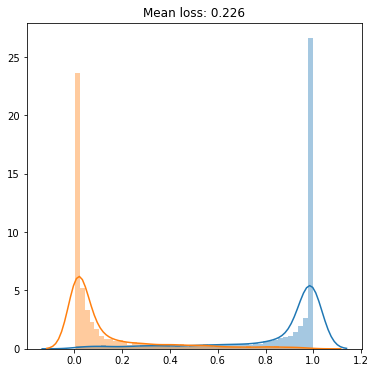

In [33]:
f, ax = plt.subplots(1,1,figsize=(6,6))
sns.distplot(preds_fake, ax=ax, label='fake')
sns.distplot(preds_real, ax=ax, label='true')
ax.set_title('Mean loss: {0:.3}'.format(np.mean(np.array(losses))))

## Weight analysis - eli5

In [34]:
for model in xgb_models:
    display(eli5.explain_weights_xgboost(model, feature_names=featNames))

Weight,Feature
0.2690,large_face_clf_mean_0_original_spaced
0.2547,large_face_clf_mean_0_bright_spaced
0.0768,large_face_clf_mean_1_bright_spaced
0.0316,large_face_clf_mean_2_bright_spaced
0.0296,large_face_clf_max_0_bright_spaced
0.0243,large_face_clf_Q3_2_bright_spaced
0.0224,large_face_clf_Q3_2_original_first
0.0194,large_face_clf_Q3_2_original_spaced
0.0187,large_face_clf_median_0_bright_spaced
0.0183,large_face_clf_median_2_original_first


Weight,Feature
0.2474,large_face_clf_mean_0_bright_spaced
0.0868,large_face_clf_Q3_2_bright_spaced
0.0849,large_face_clf_mean_0_original_spaced
0.0730,large_face_clf_Q3_0_original_spaced
0.0566,large_face_clf_Q3_2_original_spaced
0.0456,large_face_clf_mean_2_bright_spaced
0.0314,large_face_clf_median_0_bright_first
0.0298,large_face_clf_Q3_0_bright_spaced
0.0256,seq_clf_len-5_start-10_0_bright_max
0.0208,large_face_clf_median_0_bright_spaced


Weight,Feature
0.1889,large_face_clf_mean_0_bright_spaced
0.1157,large_face_clf_Q3_2_bright_spaced
0.1046,large_face_clf_Q3_2_original_spaced
0.0767,large_face_clf_mean_0_original_spaced
0.0426,large_face_clf_median_0_bright_spaced
0.0354,large_face_clf_Q3_0_bright_spaced
0.0331,large_face_clf_median_0_original_spaced
0.0316,seq_clf_len-5_start-10_0_bright_max
0.0315,large_face_clf_mean_2_original_spaced
0.0218,large_face_clf_median_0_bright_first


Weight,Feature
0.2322,large_face_clf_mean_0_bright_spaced
0.1424,large_face_clf_Q3_2_bright_spaced
0.1132,large_face_clf_Q3_0_original_spaced
0.0749,large_face_clf_Q3_2_original_spaced
0.0326,large_face_clf_mean_1_bright_first
0.0269,large_face_clf_Q3_0_bright_spaced
0.0269,large_face_clf_median_0_original_spaced
0.0233,seq_clf_len-5_start-10_0_bright_mean
0.0206,large_face_clf_max_0_bright_spaced
0.0199,large_face_clf_median_0_bright_spaced


Weight,Feature
0.1230,large_face_clf_mean_0_bright_spaced
0.1208,large_face_clf_Q3_2_bright_spaced
0.1144,large_face_clf_mean_0_original_spaced
0.1101,large_face_clf_Q3_2_original_spaced
0.0607,large_face_clf_median_0_bright_spaced
0.0419,large_face_clf_Q3_0_bright_first
0.0307,large_face_clf_Q3_0_bright_spaced
0.0262,large_face_clf_max_2_original_spaced
0.0242,large_face_clf_median_0_original_spaced
0.0237,seq_clf_len-5_start-10_0_bright_mean


In [35]:
pd.DataFrame({'Variable':featNames,
              'Importance':model.feature_importances_}).sort_values('Importance', ascending=False)

,Variable,Importance
35,large_face_clf_mean_0_bright_spaced,0.123010
59,large_face_clf_Q3_2_bright_spaced,0.120797
5,large_face_clf_mean_0_original_spaced,0.114413
29,large_face_clf_Q3_2_original_spaced,0.110127
38,large_face_clf_median_0_bright_spaced,0.060736
...,...,...
11,large_face_clf_max_1_original_first,0.000000
50,large_face_clf_mean_2_bright_first,0.000000
47,large_face_clf_std_1_bright_spaced,0.000000
18,large_face_clf_median_1_original_spaced,0.000000


## Logistic regression

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.externals import joblib
import pickle

In [37]:
losses = []
train_losses = []
preds = []
preds_real = []
preds_fake = []
lr_models = []
for fold in [0,1,2,3,4]:
    X_train, X_test, y_train, y_test = getSplitParts(fold, removeMissing=True)
    
    clf = LogisticRegression(random_state=0, 
                             max_iter=1000,
                             solver='lbfgs').fit(X_train, y_train)

    filename = str(os.path.join(DIR_EXPERIMENT,'second_level_LogReg_{0}.sav'.format(fold)))
    #pickle.dump(clf, open(filename, 'wb'))
    #clf = pickle.load(open(filename,'rb'))
    joblib.dump(clf, filename)
    clf = joblib.load(filename)
    lr_models.append(clf)
    
    y_pred = np.clip(clf.predict_proba(X_test)[:,1],eps, 1-eps)
    y_pred_train = np.clip(clf.predict_proba(X_train)[:,1],eps, 1-eps)
    #y_pred = np.clip(y_pred,0.4,1.0)
    preds.append(np.array(y_pred))
    for i, test in enumerate(y_test):
        if test > 0.5:
            preds_fake.append(y_pred[i])
        else:
            preds_real.append(y_pred[i])
    
    loss = log_loss(y_test.astype(np.float32),y_pred)
    loss_train = log_loss(y_train.astype(np.float32),y_pred_train)
    losses.append(loss)
    train_losses.append(loss_train)
    print("Fold {0} train_loss: {1:.3f}, val_loss: {2:.3f}".format(fold,loss_train,loss))

print('')
print("Mean train_loss {0:.3f}, val_loss {1:.3f}".format(np.mean(np.array(train_losses)),np.mean(np.array(losses))))
print("train loss std {0:.3f}, val loss std {1:.3f}".format(np.std(np.array(train_losses)),np.std(np.array(losses))))

Fold 0 train_loss: 0.227, val_loss: 0.272
Fold 1 train_loss: 0.229, val_loss: 0.254
Fold 2 train_loss: 0.237, val_loss: 0.221
Fold 3 train_loss: 0.222, val_loss: 0.286
Fold 4 train_loss: 0.237, val_loss: 0.220

Mean train_loss 0.230, val_loss 0.251
train loss std 0.006, val loss std 0.026


Text(0.5, 1.0, 'Mean loss: 0.251')

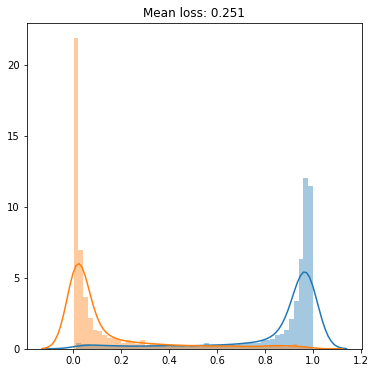

In [38]:
f, ax = plt.subplots(1,1,figsize=(6,6))
sns.distplot(preds_fake, ax=ax, label='fake')
sns.distplot(preds_real, ax=ax, label='true')
ax.set_title('Mean loss: {0:.3}'.format(np.mean(np.array(losses))))

In [39]:
for clf in lr_models:
    display(eli5.explain_weights_sklearn(clf,feature_names=featNames))

Weight?,Feature
+1.785,small_face_embedding_max_consecutive_diff
+1.717,large_face_clf_mean_0_original_spaced
+1.634,small_face_embedding_max_spaced_consecutive_diff
+1.199,seq_clf_len-5_start-10_0_bright_max
+1.121,large_face_clf_mean_0_bright_first
+1.071,large_face_clf_mean_0_bright_spaced
+1.061,large_face_clf_median_2_bright_spaced
+0.964,large_face_clf_median_0_original_spaced
+0.943,large_face_clf_max_2_original_spaced
+0.853,large_face_clf_median_2_original_first


Weight?,Feature
+2.128,small_face_embedding_max_spaced_consecutive_diff
+1.984,small_face_embedding_max_consecutive_diff
+1.771,large_face_clf_mean_0_bright_spaced
+1.660,large_face_clf_mean_0_original_spaced
+1.126,large_face_clf_max_0_bright_spaced
+1.074,large_face_clf_mean_0_bright_first
+0.975,large_face_clf_mean_2_original_spaced
+0.897,large_face_clf_mean_2_bright_spaced
+0.788,seq_clf_len-5_start-10_0_bright_max
+0.743,large_face_clf_max_0_bright_first


Weight?,Feature
+2.022,large_face_clf_mean_0_original_spaced
+1.995,small_face_embedding_max_consecutive_diff
+1.979,small_face_embedding_max_spaced_consecutive_diff
+1.570,large_face_clf_mean_0_bright_spaced
+1.384,large_face_clf_mean_2_original_spaced
+1.161,large_face_clf_mean_0_bright_first
+1.104,large_face_clf_mean_1_bright_spaced
+0.949,seq_clf_len-5_start-10_0_bright_max
+0.871,large_face_clf_std_2_bright_spaced
+0.769,large_face_clf_max_1_bright_spaced


Weight?,Feature
+1.977,small_face_embedding_max_consecutive_diff
+1.691,large_face_clf_mean_0_original_spaced
+1.469,small_face_embedding_max_spaced_consecutive_diff
+1.374,large_face_clf_mean_0_bright_spaced
+1.145,large_face_clf_Q3_0_bright_spaced
+1.073,large_face_clf_mean_2_original_spaced
+0.979,large_face_clf_Q3_1_bright_first
+0.957,small_face_embedding_max_centroid_diff
+0.954,large_face_clf_mean_0_bright_first
+0.928,seq_clf_len-5_start-10_0_bright_max


Weight?,Feature
+2.169,small_face_embedding_max_consecutive_diff
+1.951,large_face_clf_mean_0_original_spaced
+1.642,small_face_embedding_max_spaced_consecutive_diff
+1.410,large_face_clf_mean_1_bright_spaced
+1.261,large_face_clf_mean_2_original_spaced
+1.229,large_face_clf_mean_0_bright_spaced
+1.170,large_face_clf_Q3_0_bright_spaced
+0.980,large_face_clf_max_2_original_spaced
+0.934,large_face_clf_max_0_bright_spaced
+0.921,large_face_clf_max_0_bright_first


# LightGBM

In [40]:
import lightgbm as lgb

In [41]:
losses = []
train_losses = []
preds = []
preds_real = []
preds_fake = []
lgb_models = []
for fold in [0,1,2,3,4]:
    X_train, X_test, y_train, y_test = getSplitParts(fold, removeMissing=True)
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)
    
    param = {'num_leaves': 7,
             'boosting':'dart',
             'objective': 'binary',
             'metric': 'binary_logloss'}
    num_round = 300
    bst = lgb.train(param, 
                    train_data, 
                    num_round, 
                    valid_sets=[test_data],
                    #early_stopping_rounds=5,
                    verbose_eval=20)

    filename = str(os.path.join(DIR_EXPERIMENT,'second_level_lgb_{0}.txt'.format(fold)))
    bst.save_model(filename, 
                   #num_iteration=bst.best_iteration
                  )
    bst = lgb.Booster(model_file=filename)  # init model
    
    lgb_models.append(bst)
    
    y_pred = np.clip(bst.predict(X_test),eps, 1-eps)
    y_pred_train = np.clip(bst.predict(X_train),eps, 1-eps)
    preds.append(np.array(y_pred))
    for i, test in enumerate(y_test):
        if test > 0.5:
            preds_fake.append(y_pred[i])
        else:
            preds_real.append(y_pred[i])
    
    loss = log_loss(y_test.astype(np.float32),y_pred)
    loss_train = log_loss(y_train.astype(np.float32),y_pred_train)
    losses.append(loss)
    train_losses.append(loss_train)
    print("Fold {0} train_loss: {1:.3f}, val_loss: {2:.3f}".format(fold,loss_train,loss))

print('')
print("Mean train_loss {0:.3f}, val_loss {1:.3f}".format(np.mean(np.array(train_losses)),np.mean(np.array(losses))))
print("train loss std {0:.3f}, val loss std {1:.3f}".format(np.std(np.array(train_losses)),np.std(np.array(losses))))

[20]	valid_0's binary_logloss: 0.312407
[40]	valid_0's binary_logloss: 0.264065
[60]	valid_0's binary_logloss: 0.259596
[80]	valid_0's binary_logloss: 0.256504
[100]	valid_0's binary_logloss: 0.254314
[120]	valid_0's binary_logloss: 0.252072
[140]	valid_0's binary_logloss: 0.248778
[160]	valid_0's binary_logloss: 0.247906
[180]	valid_0's binary_logloss: 0.245366
[200]	valid_0's binary_logloss: 0.243158
[220]	valid_0's binary_logloss: 0.243665
[240]	valid_0's binary_logloss: 0.242915
[260]	valid_0's binary_logloss: 0.241979
[280]	valid_0's binary_logloss: 0.240497
[300]	valid_0's binary_logloss: 0.240316
Fold 0 train_loss: 0.136, val_loss: 0.240
[20]	valid_0's binary_logloss: 0.290716
[40]	valid_0's binary_logloss: 0.24676
[60]	valid_0's binary_logloss: 0.243985
[80]	valid_0's binary_logloss: 0.240241
[100]	valid_0's binary_logloss: 0.240064
[120]	valid_0's binary_logloss: 0.237569
[140]	valid_0's binary_logloss: 0.235746
[160]	valid_0's binary_logloss: 0.23525
[180]	valid_0's binary_lo

In [42]:
preds

[array([0.974717, 0.216054, 0.617881, 0.848301, ..., 0.002623, 0.036781, 0.030406, 0.029207]),
 array([0.577177, 0.445524, 0.947018, 0.944135, ..., 0.016558, 0.305598, 0.514756, 0.308094]),
 array([9.950111e-01, 1.590595e-01, 9.349898e-01, 4.053333e-01, ..., 1.072359e-03, 2.141406e-02, 4.109947e-03,
        8.438304e-04]),
 array([0.996883, 0.997083, 0.997171, 0.98984 , ..., 0.001681, 0.014913, 0.957629, 0.004475]),
 array([0.998216, 0.995063, 0.997602, 0.998249, ..., 0.002543, 0.001674, 0.001819, 0.509488])]

Text(0.5, 1.0, 'Mean loss: 0.222')

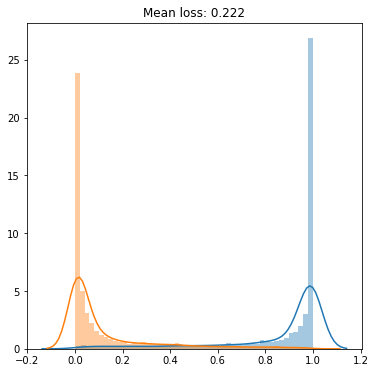

In [43]:
f, ax = plt.subplots(1,1,figsize=(6,6))
sns.distplot(preds_fake, ax=ax, label='fake')
sns.distplot(preds_real, ax=ax, label='true')
ax.set_title('Mean loss: {0:.3}'.format(np.mean(np.array(losses))))